# Import Libraries

In [1]:
from imblearn.over_sampling import SMOTE
import pandas as pd

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

# Modèles Sklearn pour la comparaison
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score,precision_score,recall_score
from sklearn.ensemble import RandomForestClassifier




# Data Loading and Filtering

In [2]:
df = pd.read_csv("../fire_test/result_filtré.csv")
try:
    drop_cols = ['class']
    if 'Unnamed: 0' in df.columns:
        drop_cols.append('Unnamed: 0')

    y = df['class']
    X = df.drop(columns=drop_cols, errors='ignore')
except FileNotFoundError:
    print("Erreur: Le fichier ../fire_test/result.csv est introuvable.")



# Train-Test Split

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Data Balancing Functions

In [4]:

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print(f"Après SMOTE: {Counter(y_train_smote)}")  

def random_undersampling(X, y):
    #Réduit la classe majoritaire pour égaler la classe minoritaire"""
    data = pd.concat([X, y], axis=1)
    count_class_0, count_class_1 = data['class'].value_counts()
    
    df_class_0 = data[data['class'] == 0]
    df_class_1 = data[data['class'] == 1]
    n_min = min(count_class_0, count_class_1)
    df_class_0_under = df_class_0.sample(n_min, random_state=42)
    df_test_under = pd.concat([df_class_0_under, df_class_1], axis=0)
    print(f"Après Undersampling: {Counter(df_test_under['class'])}")
    return df_test_under.drop('class', axis=1), df_test_under['class']

def random_oversampling(X, y):
    #Duplique la classe minoritaire pour égaler la classe majoritaire
    data = pd.concat([X, y], axis=1)
    count_class_0, count_class_1 = data['class'].value_counts()
    df_class_0 = data[data['class'] == 0]
    df_class_1 = data[data['class'] == 1]
    n_max = max(count_class_0, count_class_1)
    df_class_1_over = df_class_1.sample(n_max, replace=True, random_state=42)
    df_test_over = pd.concat([df_class_0, df_class_1_over], axis=0)
    
    print(f"Après Oversampling: {Counter(df_test_over['class'])}")
    return df_test_over.drop('class', axis=1), df_test_over['class']

print(f"Avant : {Counter(y_train)}")
X_train_over, y_train_over = random_oversampling(X_train, y_train)
X_train_under, y_train_under = random_undersampling(X_train, y_train)



c:\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


Après SMOTE: Counter({0: 1445606, 1: 1445606})
Avant : Counter({0: 1445606, 1: 2127})
Après Oversampling: Counter({0: 1445606, 1: 1445606})
Après Undersampling: Counter({0: 2127, 1: 2127})


# Random Sampling Function

In [5]:
def random_sample(X, Y, n_rows=None, n_cols=None, random_state=None):
    rng = np.random.default_rng(random_state)
    n_total_rows, n_total_cols = X.shape

    row_idx = rng.choice(n_total_rows, size=n_rows, replace=True)
    col_idx = rng.choice(n_total_cols, size=n_cols, replace=False)

    X_sample = X[row_idx[:, None], col_idx]  # shape (n_rows, n_cols)
    y_sample = Y[row_idx]                    # shape (n_rows,)

    return X_sample, y_sample, row_idx, col_idx

# Custom Random Forest Implementation

In [6]:

class DecisionTree:
    def __init__(self, tree, X_train, Y_train, X_test, Y_test):
        self.model = tree
        self.X_train = X_train
        self.Y_train = Y_train
        self.X_test = X_test
        self.Y_test = Y_test

decision_trees_count = 10
random_forest =  {
    "ouversampling": [],
    "undersampling": [],
    "SMOTE": []
}
X_y = {
    "ouversampling": (X_train_over, y_train_over),
    "undersampling": (X_train_under, y_train_under),
    "SMOTE": (X_train_smote, y_train_smote)
}
rows_number = X_train.shape[0]
cols_number = int(np.sqrt(X_train.shape[1]))
for name, (X_train, y_train) in X_y.items():
    for i in range(decision_trees_count):
        X_train_sample, Y_train_sample, row_idx, col_idx = random_sample(X_train.values, y_train.values, rows_number, cols_number, i)
        X_test_sample = X_test.values[:, col_idx]

        tree = DecisionTree(DecisionTreeClassifier(random_state=i), X_train_sample, Y_train_sample, X_test_sample, y_test)
        random_forest[name].append(tree)
        tree.model.fit(X_train_sample, Y_train_sample)
        

# Custom Random Forest Evaluation

ouversampling
Accuracy : 0.9575557974658363
Precision: 0.03276622558286074
Recall   : 0.9774436090225563
F1 Score : 0.06340690159736617
              precision    recall  f1-score   support

           0       1.00      0.96      0.98    361402
           1       0.03      0.98      0.06       532

    accuracy                           0.96    361934
   macro avg       0.52      0.97      0.52    361934
weighted avg       1.00      0.96      0.98    361934



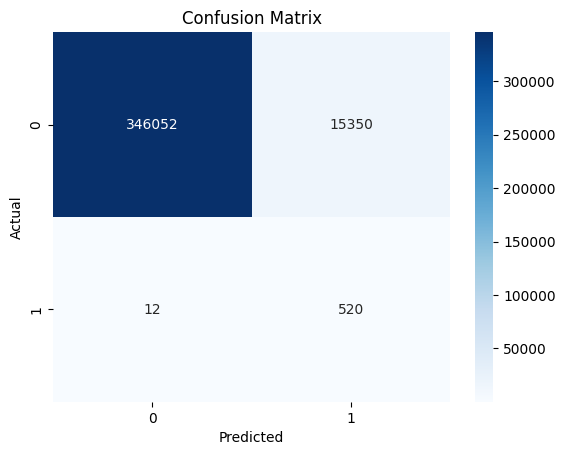

undersampling
Accuracy : 0.8425817966811628
Precision: 0.009165695601509644
Recall   : 0.9906015037593985
F1 Score : 0.018163332127039928
              precision    recall  f1-score   support

           0       1.00      0.84      0.91    361402
           1       0.01      0.99      0.02       532

    accuracy                           0.84    361934
   macro avg       0.50      0.92      0.47    361934
weighted avg       1.00      0.84      0.91    361934



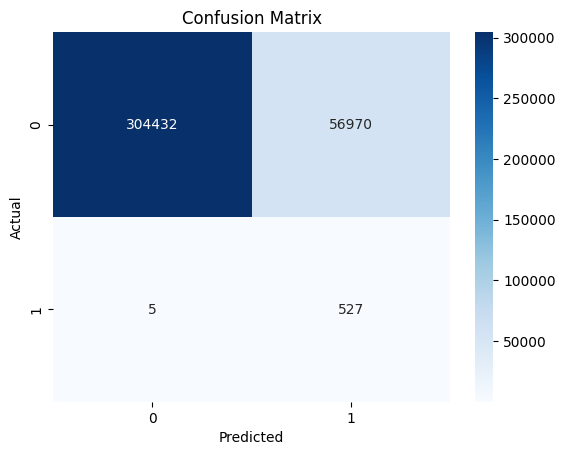

SMOTE
Accuracy : 0.9628468173755436
Precision: 0.03646543679563563
Recall   : 0.9548872180451128
F1 Score : 0.07024821959482819
              precision    recall  f1-score   support

           0       1.00      0.96      0.98    361402
           1       0.04      0.95      0.07       532

    accuracy                           0.96    361934
   macro avg       0.52      0.96      0.53    361934
weighted avg       1.00      0.96      0.98    361934



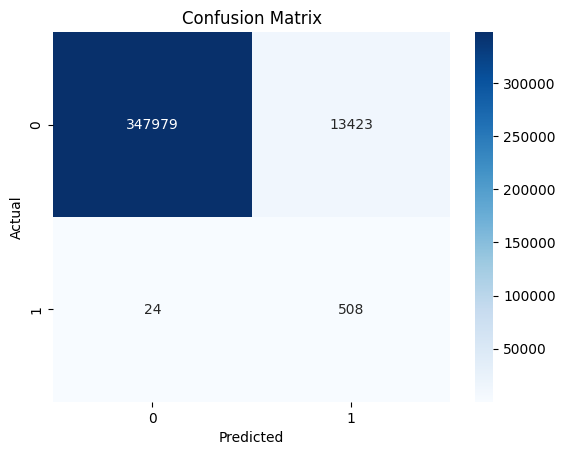

In [7]:

for name in ("ouversampling","undersampling","SMOTE"):
    preds = np.zeros((y_test.shape[0], decision_trees_count))
    for i, tree in enumerate(random_forest[name]):
        y_preds = tree.model.predict(tree.X_test)
        preds[:, i] = y_preds
        

    preds = np.array([Counter(preds[i, :]).most_common(1)[0][0] for i in range(preds.shape[0])])
    print(name)
    print("Accuracy :", accuracy_score(y_test, preds))
    print("Precision:", precision_score(y_test, preds, average='binary'))
    print("Recall   :", recall_score(y_test, preds, average='binary'))
    print("F1 Score :", f1_score(y_test, preds, average='binary'))
    print(classification_report(y_test, preds))
    cm = confusion_matrix(y_test, preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()




# Sklearn Random Forest Evaluation


OUVERSAMPLING
Accuracy : 0.9997126547934154
Precision: 0.9262948207171314
Recall   : 0.8740601503759399
F1 Score : 0.8994197292069632
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    361402
           1       0.93      0.87      0.90       532

    accuracy                           1.00    361934
   macro avg       0.96      0.94      0.95    361934
weighted avg       1.00      1.00      1.00    361934



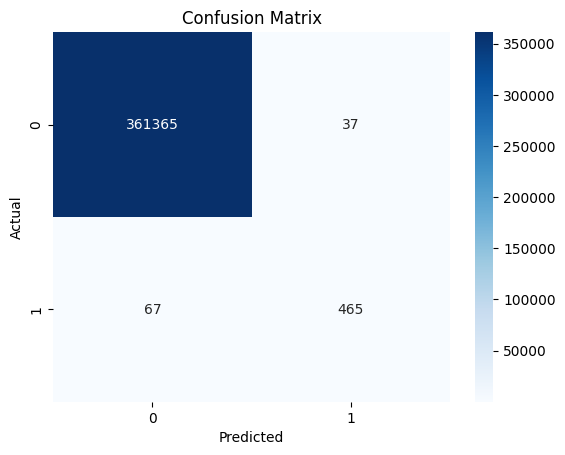


UNDERSAMPLING
Accuracy : 0.9720529157249664
Precision: 0.04928981281158875
Recall   : 0.9849624060150376
F1 Score : 0.09388157305383857
              precision    recall  f1-score   support

           0       1.00      0.97      0.99    361402
           1       0.05      0.98      0.09       532

    accuracy                           0.97    361934
   macro avg       0.52      0.98      0.54    361934
weighted avg       1.00      0.97      0.98    361934



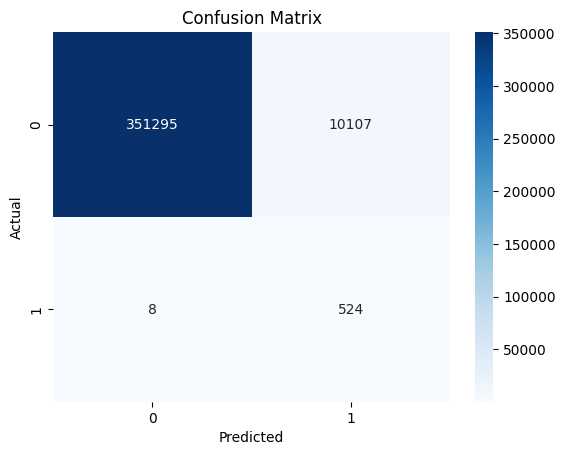


SMOTE
Accuracy : 0.9996767366425923
Precision: 0.8922495274102079
Recall   : 0.8872180451127819
F1 Score : 0.8897266729500471
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    361402
           1       0.89      0.89      0.89       532

    accuracy                           1.00    361934
   macro avg       0.95      0.94      0.94    361934
weighted avg       1.00      1.00      1.00    361934



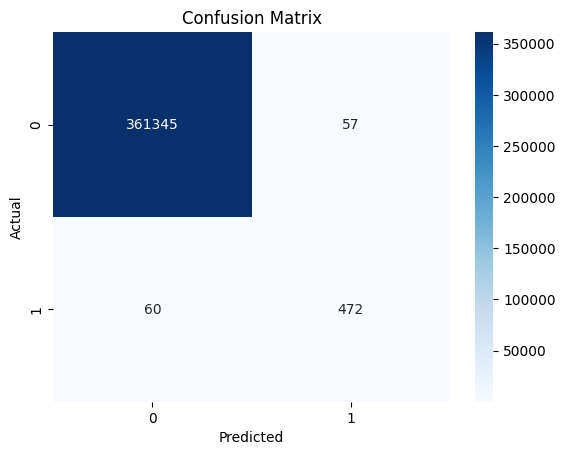

In [8]:
random_forest = RandomForestClassifier(n_estimators=10, random_state=42)
for name, (X_train, y_train) in X_y.items():
    
    random_forest.fit(X_train, y_train)
    print(f"\n{name.upper()}")
    
    preds = random_forest.predict(X_test)
    print("Accuracy :", accuracy_score(y_test, preds))
    print("Precision:", precision_score(y_test, preds, average='binary'))
    print("Recall   :", recall_score(y_test, preds, average='binary'))
    print("F1 Score :", f1_score(y_test, preds, average='binary'))
    print(classification_report(y_test, preds))
    cm = confusion_matrix(y_test, preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

